In [ ]:
import zipfile
import os
import glob
import cv2
import numpy as np
import concurrent.futures
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
import subprocess
import random
import shutil

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Unzip dataset
# https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
zip_path = "vegetable-image-dataset.zip"
extract_to = r"C:\Users\Ashref\Documents\LAST VERSION"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
#  dataset root folder
DATASET_DIR = r"C:\Users\Ashref\Documents\LAST VERSION\Vegetable Images"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")

#  target image size
IMG_HEIGHT, IMG_WIDTH = 224, 224

# List of class names
CLASSES = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 
           'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 
           'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

In [6]:
# Define minimal expected resolution (224x224)
MIN_WIDTH = IMG_WIDTH
MIN_HEIGHT = IMG_HEIGHT

def get_image_resolution(image_path):
    """
    Uses ExifTool to retrieve the width and height of an image.
    Returns two numbers: width and height.
    """
    # Adjust the path to exiftool.exe if necessary (here for Windows)
    command = [r"C:\Program Files\exiftool\exiftool.exe", "-s", "-s", "-s", "-ImageWidth", "-ImageHeight", image_path]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    output = result.stdout.strip()
    parts = output.split()
    if len(parts) >= 2:
        try:
            width = int(parts[0])
            height = int(parts[1])
            return width, height
        except Exception as e:
            print(f"Erreur de conversion pour {image_path}: {e}")
            return None, None
    else:
        print(f"Format inattendu des métadonnées pour {image_path}: {output}")
        return None, None

def process_file(image_path):
    """
    Processes a single image:
    - Retrieves resolution via ExifTool.
    - If metadata is missing or resolution is below threshold, deletes the image.
    Returns True if the file was removed, False otherwise.
    """
    width, height = get_image_resolution(image_path)
    if width is None or height is None:
        print(f"❌ Métadonnées manquantes ou incorrectes pour {image_path}. L'image sera supprimée.")
        try:
            os.remove(image_path)
        except Exception as e:
            print(f"Erreur lors de la suppression de {image_path}: {e}")
        return True
    if width < MIN_WIDTH or height < MIN_HEIGHT:
        print(f"❌ Image {os.path.basename(image_path)} a une résolution trop basse: {width}x{height}. Elle sera supprimée.")
        try:
            os.remove(image_path)
        except Exception as e:
            print(f"Erreur lors de la suppression de {image_path}: {e}")
        return True
    return False

# Collect all image paths from DATASET_DIR recursively
all_files = []
for root, dirs, files in os.walk(DATASET_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            all_files.append(os.path.join(root, file))

total_images = len(all_files)
print(f"Total images to process with ExifTool filtering: {total_images}")

# Process files in parallel using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, all_files))
    removed_count = sum(results)

print(f"✅ Filtrage ExifTool terminé : {removed_count} images non conformes supprimées sur {total_images} vérifiées.")


Total images to process with ExifTool filtering: 21000
❌ Image 1246.jpg a une résolution trop basse: 224x207. Elle sera supprimée.
❌ Image 0430.jpg a une résolution trop basse: 224x193. Elle sera supprimée.
❌ Image 0526.jpg a une résolution trop basse: 224x205. Elle sera supprimée.
❌ Image 0609.jpg a une résolution trop basse: 224x200. Elle sera supprimée.
❌ Image 0126.jpg a une résolution trop basse: 224x211. Elle sera supprimée.
❌ Image 0176.jpg a une résolution trop basse: 224x198. Elle sera supprimée.
❌ Image 0741.jpg a une résolution trop basse: 224x210. Elle sera supprimée.
❌ Image 1138.jpg a une résolution trop basse: 224x187. Elle sera supprimée.
❌ Image 1150.jpg a une résolution trop basse: 224x223. Elle sera supprimée.
✅ Filtrage ExifTool terminé : 9 images non conformes supprimées sur 21000 vérifiées.


In [7]:
def is_blurry(image_path, threshold=100.0):
    """
    Returns True if the image is blurry based on the variance of the Laplacian.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True  # Consider unreadable images as blurry
    variance = cv2.Laplacian(img, cv2.CV_64F).var()
    return variance < threshold

# Loop over dataset folders and remove blurry images
for dataset_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in CLASSES:
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.exists(class_dir):
            continue
        images_before = os.listdir(class_dir)
        count_before = len(images_before)
        for image_name in images_before:
            image_path = os.path.join(class_dir, image_name)
            if is_blurry(image_path):
                os.remove(image_path)
        images_after = os.listdir(class_dir)
        count_after = len(images_after)
        print(f"Dataset: {os.path.basename(dataset_dir)}, Class: {class_name} | Before: {count_before}, After: {count_after}")


Dataset: train, Class: Bean | Before: 1000, After: 975
Dataset: train, Class: Bitter_Gourd | Before: 997, After: 995
Dataset: train, Class: Bottle_Gourd | Before: 1000, After: 999
Dataset: train, Class: Brinjal | Before: 1000, After: 992
Dataset: train, Class: Broccoli | Before: 1000, After: 1000
Dataset: train, Class: Cabbage | Before: 1000, After: 1000
Dataset: train, Class: Capsicum | Before: 1000, After: 788
Dataset: train, Class: Carrot | Before: 1000, After: 882
Dataset: train, Class: Cauliflower | Before: 1000, After: 998
Dataset: train, Class: Cucumber | Before: 1000, After: 964
Dataset: train, Class: Papaya | Before: 997, After: 933
Dataset: train, Class: Potato | Before: 1000, After: 613
Dataset: train, Class: Pumpkin | Before: 1000, After: 1000
Dataset: train, Class: Radish | Before: 1000, After: 928
Dataset: train, Class: Tomato | Before: 1000, After: 938
Dataset: validation, Class: Bean | Before: 200, After: 198
Dataset: validation, Class: Bitter_Gourd | Before: 200, After

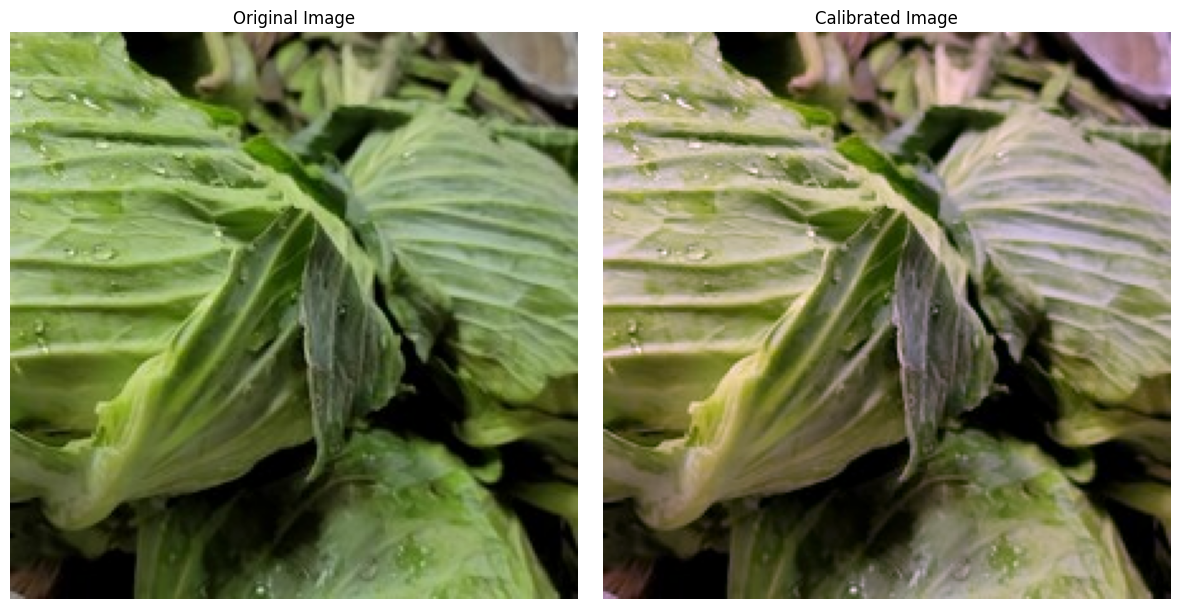

✅ Color calibration completed in place!


In [8]:
def improved_color_calibration(image, roi, target_white=(240, 240, 240), gain_limit=(0.7, 1.3)):
    """
    Performs white balance correction based on a white reference patch.
    
    Parameters:
      image        : Input image (BGR format)
      roi          : Region-of-interest (x, y, w, h) containing the white patch.
      target_white : Desired white point (B, G, R)
      gain_limit   : Allowed range for channel gains (min, max)
      
    Returns:
      calibrated   : Color-corrected image (BGR, uint8)
    """
    x, y, w, h = roi
    patch = image[y:y+h, x:x+w]
    avg_bgr = np.mean(patch, axis=(0, 1))
    avg_rgb = avg_bgr[::-1]  # Convert to RGB order
    target_rgb = np.array(target_white[::-1], dtype=np.float32)
    epsilon = 1e-6
    scales = target_rgb / (avg_rgb + epsilon)
    min_scale = np.min(scales)
    scales = scales / min_scale
    scales = np.clip(scales, gain_limit[0], gain_limit[1])
    scales_bgr = scales[::-1]
    calibrated = image.astype(np.float32)
    calibrated[..., 0] *= scales_bgr[0]
    calibrated[..., 1] *= scales_bgr[1]
    calibrated[..., 2] *= scales_bgr[2]
    calibrated = np.clip(calibrated, 0, 255).astype(np.uint8)
    return calibrated

# Define ROI for your ColorChecker Passport white patch (adjust as needed)
roi = (50, 50, 50, 50)

# Demonstrate on a random image from any dataset folder
classes_all = sorted(set(os.listdir(TRAIN_DIR) + os.listdir(VAL_DIR) + os.listdir(TEST_DIR)))
example_class = random.choice(classes_all)
example_dir = random.choice([TRAIN_DIR, VAL_DIR, TEST_DIR])
example_class_path = os.path.join(example_dir, example_class)
example_images = sorted(os.listdir(example_class_path))
example_img_path = os.path.join(example_class_path, example_images[0])

original_img = cv2.imread(example_img_path)
if original_img is not None:
    calibrated_img = improved_color_calibration(original_img, roi, target_white=(240,240,240), gain_limit=(0.7,1.3))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(calibrated_img, cv2.COLOR_BGR2RGB))
    plt.title("Calibrated Image")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Error: Could not load example image for calibration demonstration.")

# Process all images in place with color calibration
for dataset_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for class_name in CLASSES:
        class_dir = os.path.join(dataset_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(class_dir, file)
                image = cv2.imread(file_path)
                if image is None:
                    print("Warning: Could not read", file_path)
                    continue
                calibrated = improved_color_calibration(image, roi, target_white=(220,220,220), gain_limit=(0.8,1.2))
                cv2.imwrite(file_path, calibrated)
print("✅ Color calibration completed in place!")


In [9]:
def augment_image(image, angle=15, scale=1.1, brightness=30, contrast=1.0, flip=False, noise_std=0):
    """
    Applies rotation, scaling, brightness, and contrast adjustments.
    Optionally applies horizontal flip and Gaussian noise.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    # Rotation and scaling
    M = cv2.getRotationMatrix2D(center, angle, scale)
    augmented = cv2.warpAffine(image, M, (w, h))
    # Brightness and contrast adjustment
    augmented = cv2.convertScaleAbs(augmented, alpha=contrast, beta=brightness)
    # Horizontal flip if requested
    if flip:
        augmented = cv2.flip(augmented, 1)
    # Optionally add Gaussian noise
    if noise_std > 0:
        noise = np.random.normal(0, noise_std, augmented.shape).astype(np.float32)
        augmented = augmented.astype(np.float32) + noise
        augmented = np.clip(augmented, 0, 255).astype(np.uint8)
    return augmented

def augment_and_save(image_path, save_dir, augmentations=[(15, 1.0, 20, 1.0, False, 0), 
                                                        (-15, 1.0, -20, 1.0, False, 0),
                                                        (0, 1.0, 0, 1.0, True, 0)]):
    """
    Loads an image from image_path, applies each augmentation defined in the augmentations list,
    and saves the augmented images in the same folder (save_dir).
    Each augmentation is a tuple: (angle, scale, brightness, contrast, flip, noise_std).
    Skips processing images that have already been augmented (detected by '_aug' in filename).
    """
    img = cv2.imread(image_path)
    if img is None:
        return
    base_name = os.path.basename(image_path)
    name, ext = os.path.splitext(base_name)
    if "_aug" in name:
        return  # Skip already augmented images
    for idx, (angle, scale, brightness, contrast, flip, noise_std) in enumerate(augmentations):
        aug = augment_image(img, angle=angle, scale=scale, brightness=brightness,
                            contrast=contrast, flip=flip, noise_std=noise_std)
        aug_filename = os.path.join(save_dir, f"{name}_aug{idx}{ext}")
        cv2.imwrite(aug_filename, aug)

# Augment only the train set
for class_name in CLASSES:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if not os.path.exists(class_dir):
        continue
    for file in os.listdir(class_dir):
        if file.lower().endswith(('.png','.jpg','.jpeg','.bmp','.gif')):
            image_path = os.path.join(class_dir, file)
            augment_and_save(image_path, class_dir, 
                             augmentations=[(15, 1.0, 20, 1.0, False, 0), 
                                            (-15, 1.0, -20, 1.0, False, 0),
                                            (0, 1.0, 0, 1.0, True, 0)])
print("✅ Offline augmentation completed on the TRAIN folder in place!")


✅ Offline augmentation completed on the TRAIN folder in place!


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)


Found 2836 files belonging to 15 classes.
Found 2814 files belonging to 15 classes.


In [11]:
# Build a CNN using EfficientNetB0 with transfer learning
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze base model initially

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = models.Model(inputs, outputs)
model.summary()

# Set up callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_vegetable_model.h5", monitor='val_loss', save_best_only=True)
tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Prepare training dataset from the train directory (after offline augmentation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=42
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Found 56020 files belonging to 15 classes.


In [12]:

EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, tensorboard_cb]
)


Epoch 1/5
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.7459 - loss: 1.1991

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1601s 908ms/step - accuracy: 0.7460 - loss: 1.1987 - val_accuracy: 0.9873 - val_loss: 0.1269
Epoch 2/5
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9861 - loss: 0.1226

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1600s 913ms/step - accuracy: 0.9861 - loss: 0.1226 - val_accuracy: 0.9954 - val_loss: 0.0497
Epoch 3/5
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9937 - loss: 0.0555

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1823s 1s/step - accuracy: 0.9937 - loss: 0.0555 - val_accuracy: 0.9968 - val_loss: 0.0271
Epoch 4/5
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9961 - loss: 0.0321

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 2018s 1s/step - accuracy: 0.9961 - loss: 0.0321 - val_accuracy: 0.9975 - val_loss: 0.0170
Epoch 5/5
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9970 - loss: 0.0219

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 1471s 840ms/step - accuracy: 0.9970 - loss: 0.0219 - val_accuracy: 0.9986 - val_loss: 0.0117


In [13]:
# Evaluate on validation and test sets
val_loss, val_accuracy = model.evaluate(val_ds)
print("Validation Accuracy: {:.3f}".format(val_accuracy))
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Accuracy: {:.3f}".format(test_accuracy))

89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 677ms/step - accuracy: 0.9995 - loss: 0.0100
Validation Accuracy: 0.999
88/88 ━━━━━━━━━━━━━━━━━━━━ 58s 662ms/step - accuracy: 0.9982 - loss: 0.0134
Test Accuracy: 0.998


In [14]:
# # Cell: Fine-Tuning the Model

# # Unfreeze the base model for fine-tuning
# base_model.trainable = True
# # Freeze all layers except the last 4 layers of the base model
# fine_tune_at = len(base_model.layers) - 4
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Re-compile the model with a lower learning rate
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Fine-tuning for additional epochs (e.g., 4 more epochs)
# fine_tune_epochs = 4
# total_epochs = EPOCHS + fine_tune_epochs

# history_fine = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=total_epochs,
#     initial_epoch=EPOCHS,
#     callbacks=[early_stop, checkpoint, tensorboard_cb]
# )


In [15]:
def plot_loss_curves(history):
    """Plots training and validation loss and accuracy curves."""
    display(HTML("<h3 style='text-align:center; font-weight:bold; color:#16A085'>Model Performance Curves</h3><hr>"))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(20, 7))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss Curves", size=20)
    plt.xlabel("Epochs", size=20)
    plt.ylabel("Loss", size=20)
    plt.legend(fontsize=15)
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title("Accuracy Curves", size=20)
    plt.xlabel("Epochs", size=20)
    plt.ylabel("Accuracy", size=20)
    plt.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()



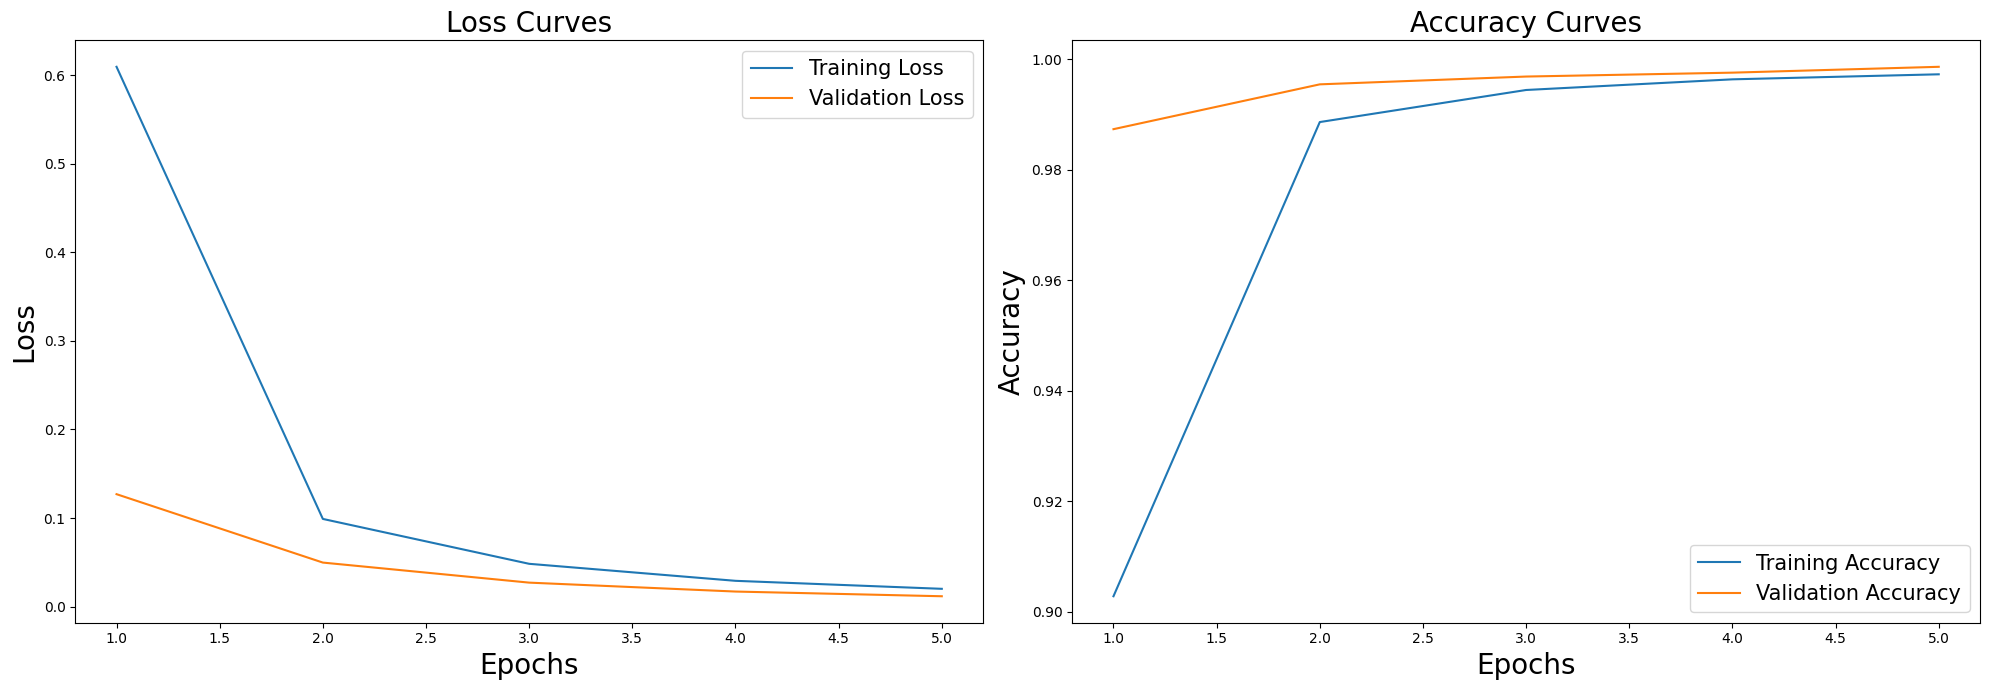

88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 705ms/step


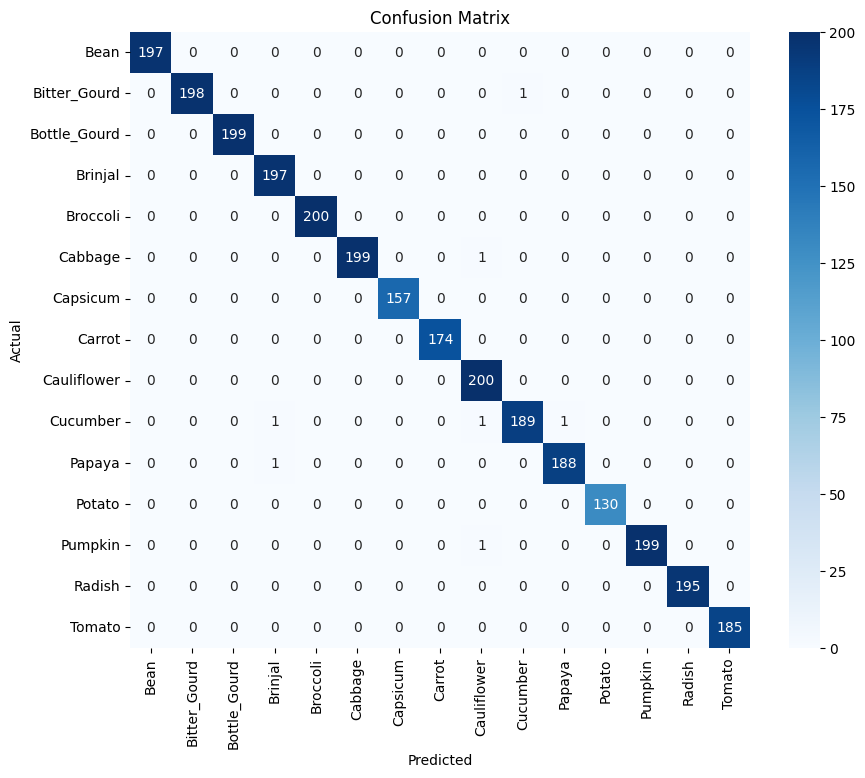

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       197
Bitter_Gourd       1.00      0.99      1.00       199
Bottle_Gourd       1.00      1.00      1.00       199
     Brinjal       0.99      1.00      0.99       197
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      0.99      1.00       200
    Capsicum       1.00      1.00      1.00       157
      Carrot       1.00      1.00      1.00       174
 Cauliflower       0.99      1.00      0.99       200
    Cucumber       0.99      0.98      0.99       192
      Papaya       0.99      0.99      0.99       189
      Potato       1.00      1.00      1.00       130
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       195
      Tomato       1.00      1.00      1.00       185

    accuracy                           1.00      2814
   macro avg       1.00      1.00      1.00      2814
weighted avg       1.00   

In [16]:
def plot_confusion_matrix(cm, class_names):
    """Displays a confusion matrix using seaborn heatmap."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure the cell containing the definition of `history` is executed before this cell
if 'history' in globals():
    # Plot loss and accuracy curves using the training history
    plot_loss_curves(history)
else:
    print("Error: 'history' is not defined. Please ensure the training cell is executed.")

# Get predictions for the test dataset
predictions = model.predict(test_ds)
pred_labels = np.argmax(predictions, axis=1)

# Collect true labels from test_ds
true_labels = []
for _, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
true_labels = np.array(true_labels)

# Generate and plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, CLASSES)

# Print a detailed classification report
print(classification_report(true_labels, pred_labels, target_names=CLASSES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


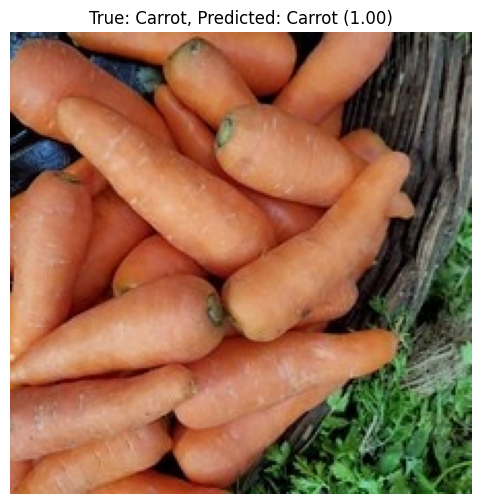

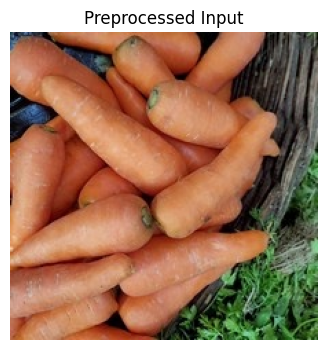

In [22]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def compare_true_vs_pred(image_path, true_class, model, class_names, roi=(50,50,50,50)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image from {image_path}")
        return
    
    # (Skip calibration here if images on disk are already processed)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    input_img = cv2.resize(image_rgb, (224, 224))
    
    # Convert to float32 and apply EfficientNet's preprocessing (which scales to [-1, 1])
    input_img = input_img.astype("float32")
    input_img = preprocess_input(input_img)
    
    # Expand dimensions for prediction
    input_img = np.expand_dims(input_img, axis=0)
    
    preds = model.predict(input_img)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)
    
    plt.figure(figsize=(8,6))
    plt.imshow(image_rgb)
    plt.title(f"True: {true_class}, Predicted: {pred_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(4,4))
    plt.imshow((input_img[0] + 1) / 2 if np.min(input_img) < 0 else input_img[0].astype("uint8"))
    plt.title("Preprocessed Input")
    plt.axis('off')
    plt.show()

compare_true_vs_pred(r"C:\Users\Ashref\Documents\LAST VERSION\Vegetable Images\test\Carrot\1005.jpg", "Carrot", model, CLASSES) 


In [18]:
%%writefile streamlit_app.py
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model (ensure the model file is in the same directory)
model = tf.keras.models.load_model("best_vegetable_model.h5")

# Class names (must match your training labels)
CLASSES = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 
           'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 
           'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

st.title("Vegetable Classifier Demo")
st.write("Upload an image or use the webcam to classify vegetables.")

# Sidebar: Choose input mode
input_mode = st.sidebar.radio("Select Input Mode", ("Upload Image", "Webcam"))

def preprocess_image(image: np.ndarray) -> np.ndarray:
    # Resize image to target size
    image = cv2.resize(image, (224, 224))
    image = image.astype("float32")
    # Use EfficientNet's preprocessing to scale input to [-1, 1]
    image = preprocess_input(image)
    return image

if input_mode == "Upload Image":
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        # Load the image and display it
        image = np.array(Image.open(uploaded_file).convert("RGB"))
        st.image(image, caption="Uploaded Image", use_column_width=True)
        
        # Preprocess the image using our defined function
        input_img = preprocess_image(image)
        input_img = np.expand_dims(input_img, axis=0)
        
        # Get prediction
        preds = model.predict(input_img)
        pred_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds)
        
        st.write("Prediction:", pred_class)
        st.write("Confidence:", confidence)
elif input_mode == "Webcam":
    st.write("Click 'Start' to use your webcam.")
    run = st.checkbox("Start")
    FRAME_WINDOW = st.image([])
    cap = cv2.VideoCapture(0)
    if run:
        while True:
            ret, frame = cap.read()
            if not ret:
                st.write("Failed to capture image")
                break
            # Convert captured frame from BGR to RGB and display it
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            FRAME_WINDOW.image(frame_rgb)
            
            # Preprocess the frame
            input_frame = preprocess_image(frame_rgb)
            input_frame = np.expand_dims(input_frame, axis=0)
            
            preds = model.predict(input_frame)
            pred_class = CLASSES[np.argmax(preds)]
            confidence = np.max(preds)
            
            # Draw prediction text on the frame and display it in Streamlit
            cv2.putText(frame, f"{pred_class}: {confidence:.2f}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            st.write("Prediction:", pred_class, "Confidence:", confidence)
            break
    cap.release()

st.write("✅ Demo complete!")
st.write("📦 Source code saved to 'streamlit_app.py'")


Writing streamlit_app.py
